# SI 370F17 - Homework 7 - Language Clustering

## Objectives
* Practice loading in data for hierarchical clustering
* Configuring/Running/Interpreting hierarchical clustering

## Please fill in...
### * Your name: AJ Goldstein
### * People you worked with:  I worked by myself

## **Submission Instructions:**
After completing this homework, you should turn in two files via Canvas:
1. A Jupyter Notebook file named hw8-YOUR_UNIQUE_NAME.ipynb.  Please observe the following requirements:
    * This file should show all of the required work, including code, results, visualizations (if any), and necessary comments to your code.
    * You should use Markdown cells to enclose all textual content, including explanations, discoveries, and conclusions. Do not include such content unless required.
    * Irrelevant code and results should be deleted prior to submission.
2. An html file named hw8-YOUR_UNIQUE_NAME.html showing the preview of the above Jupyter Notebook. To create this file, select File > Download as HTML. We want this in case something breaks when we load your notebook.  This will let us see what you saw when you were done.


## Load the libraries we need

In [1]:
import numpy as np
import scipy as sp
import os
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.mixture as skmix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

# make the Pandas tables a little more readable
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

## Clustering Language

One of the nice features of hierarchical clustering is that it can build things that closely resemble phylogenetic trees.  Phylogenetic trees look at different animal species and based on their DNA or other information attempt to reconstruct the evolutionary tree.

Imagine a 100000 years ago, some species (that may not exist today) had some DNA sequence that read "ATAGC."  Around that time, due to mutation, some animals born ot that species had some critical mutation.  Let's say that the last C changed to a G.  Now we have:  Species 1 with ATAGC and Species 2 with ATAGG.  Over time, each sub-species may have mutated some more, and the longer the time period, the more mutations.  So maybe today we see:  AAAGG and AGAGC.  What we want know is: how related are these two species? and when was there likely a common ancestor?

Hierarchical clustering can partially tell us this (though usually we'd do something more sophisticated than the simple variants we've seen in class).  Related species get clustered together and the where they "merge" in the dendogram is related to when there was a common species (so the "distance" of the merge).

It turns out we can do the same thing with language.  Languages have evolved over time from a few key sources.  Here's one model of this:

![](langvis.jpg "langvis")

<b>We're going to try to rebuild this with hierarchical clustering.</b>  To make this work, we need some "common" piece of text in many languages and then some way to represent "genes."  For the first part, we're going to use the bible (specifically, the first part of Genesis). It's convenient because so many languages have biblical translations.  You can find these in the hw8-data directory.

To start, we're going to assume something pretty dumb:  letters will encode "genes" of a language. We're simply going to count the number of a's, b's, c's etc. used by each language for the Genesis text. If two languages are similar, they should use very similar character distributions.  For example, Spanish and Portugese use a similar number of a's in the text.

To start, we're going to load the text for you. Inside of the "genesis" dictionary you'll find the "key" is the name of the language, and the value is a list corresponding to the lines in Genesis for that lagnage.

For example:

English -> ['"In the beginning God created the heaven and the earth."\n','"And the earth was without form,...]

Spanish -> ['"En el principio creó Dios los cielos y la tierra"\n','"Y la tierra estaba sin orden y...]

In [2]:
genesis = {}

for file in os.listdir("./hw8-data"):
    if file.endswith(".gen"):  # we only want the genesis files
        # strip out the language name
        lang = file[0:file.index(".")]
        # read in all the lines
        with open("./hw8-data/"+file) as f:
            content = f.readlines()
            # populate the dictionary
            genesis[lang] = content

### <span style="color:red"> NOTE TO SELF: Dr. Teplovs writes code and comments that read like a story. It's so beautiful :)</span>

In [3]:
# test
print("The first line of Genesis in English is",genesis["English"][0])
print("The first line of Genesis in French is",genesis["French"][0])

The first line of Genesis in English is "In the beginning God created the heaven and the earth."

The first line of Genesis in French is "Au commencement, Dieu créa les cieux et la terre."



### Part 1: Create the DataFrame

Your first job is to create a DataFrame with the right data.  Each row should be a language and each column should be a letter. The cell should be the number of times that letter appears in the text for tha language.  Here's a sample:

![](frame_sample.png "sample")

When you build this DataFrame:

1) Call this frame df_lang

2) Make everything lowercase

3) Only keep alphanumeric characters:  a-z (including the weird vowels like umlauts) and 0-9 (but there shouldn't be any numbers)

4) Ignore whitespaces

5) The count should be all the letters in the entire document, not just the first line (so, hint: you might want to concatenate lines into one string before you get going)

6) The order of the columns doesn't matter, but if you want it lexicographically sorted, do this:

`df_lang = df_lang.reindex_axis(sorted(df_lang.columns), axis=1)`


In [45]:
from collections import Counter

# STEP ONE: get all letters across all languages
all_lang_letters = Counter({})
for lang in genesis:
    for line in genesis[lang]:
        current_line_count = Counter(line.lower()) # get letter count for current line
        all_lang_letters += current_line_count # index for all languages
        
# STEP TWO: only keep the alphanumeric characters you want
all_lang_letters = {key: value for key, value in all_lang_letters.items() if key.isalpha()}

# STEP THREE: gather individual language counts
df_lang = pd.DataFrame()
for lang in genesis:
    current_lang = Counter({key: 0 for key in all_lang_letters})
    for line in genesis[lang]:
        current_line_count = Counter(line.lower()) # get letter count for current line
        current_line_count = Counter({key: value for key, value in current_line_count.items() if key.isalpha()}) # clean up
        current_lang.update(current_line_count.elements()) # index for current language
        
    df_row = pd.DataFrame(current_lang, index=[lang,]) # make DataFrame row out of totals
    df_lang = df_lang.append(df_row) # append row to DataFrame of all languages

In [46]:
df_lang

a    b    c    d    e   f    g    h    i    j ...   ś   ş   š  \
Albanian    219   73    3  163  296  29   35  165  257  127 ...   0   0   0   
Czech       192  108   34  109  212   0    0   70  108   59 ...   0   0  27   
Danish      141   43    0  244  474  55  199   43   83   31 ...   0   0   0   
Dutch       206   20   29  208  547   4  107   91  108   26 ...   0   0   0   
English     300   32   31  233  451  87  114  256  198    0 ...   0   0   0   
Finnish     499    0    0   30  227   0    1   66  286  159 ...   0   0   0   
French      217   29   76  137  534  31    7    7  258   14 ...   0   0   0   
German      236   47  107  255  522  53  117  152  177    9 ...   0   0   0   
Hungarian   251   20   12   83  338  40  116   36  109   28 ...   0   0   0   
Icelandic   219    5    0   62   97  83  192   39  269   57 ...   0   0   0   
Italian     245   32  158  104  430  37   49   30  293    0 ...   0   0   0   
Latin       241   40   93   93  451  41   20    9  267    0 ...   0   0   0   
Lithuanian  339   30    0  124  166   0   57    0  339   40 ...   0   0  40   
Norwegian   133   35    0  172  388  54  208   40  100   31 ...   0   0   0   
Polish      250   90  105  134  276   0   56   22  387   47 ...  25   0   0   
Portuguese  364   31   51  136  421  44   31   31  179    8 ...   0   0   0   
Romanian    318   17  113  101  353  59    4    6  280    1 ...   0  75   0   
Serbian     199   99    8  123  256   0   43   17  247   86 ...   0   0  24   
Slovak      254  104   42  128  210   0    0   93  125   42 ...   0   0  21   
Slovene     189  100    6  119  360   0   58   24  282  173 ...   0   0  14   
Spanish     381   57   63  170  406  30   35   25  168   19 ...   0   0   0   
Swedish     264   19   93  227  334  65   99  116   81   55 ...   0   0   0   

             ţ  ť   ū   ů   ų   ż   ž  
Albanian     0  0   0   0   0   0   0  
Czech        0  2   0  33   0   0  45  
Danish       0  0   0   0   0   0   0  
Dutch        0  0   0   0   0   0   0  
English      0  0   0   0   0   0   0  
Finnish      0  0   0   0   0   0   0  
French       0  0   0   0   0   0   0  
German       0  0   0   0   0   0   0  
Hungarian    0  0   0   0   0   0   0  
Icelandic    0  0   0   0   0   0   0  
Italian      0  0   0   0   0   0   0  
Latin        0  0   0   0   0   0   0  
Lithuanian   0  0  22   0  25   0  40  
Norwegian    0  0   0   0   0   0   0  
Polish       0  0   0   0   0  24   0  
Portuguese   0  0   0   0   0   0   0  
Romanian    35  0   0   0   0   0   0  
Serbian      0  0   0   0   0   0  14  
Slovak       0  1   0   0   0   0  34  
Slovene      0  0   0   0   0   0  27  
Spanish      0  0   0   0   0   0   0  
Swedish      0  0   0   0   0   0   0  

[22 rows x 77 columns]

In [47]:
## Test your code
print("The number of a's in Slovene is",df_lang.ix['Slovene']['a'])
print("The total number of characters in Spanish is",df_lang.ix['Spanish'].sum())

The number of a's in Slovene is 189
The total number of characters in Spanish is 2925


/Users/AJGoldstein/anaconda/envs/si370/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


### Part 2: Perform hierarchical clustering

Produce hiearchical clustering for df_lang.  You should try different distance metrics (e.g., cosine, euclidean, etc.) and different linkage measuers (complete, ward, single, etc.). Find a configuration that produces a denrogram that is close to the "ground truth" in the picture above.  You will *not* get a perfect fit. Single characters are so-so, we don't have a lot of text, etc.

Also: Latin is a weird one because it's the root of many other languages but is still "in use" today (sort of).  So in our case it's a "leaf" but in the diagram above it is a "intermediate" language.

Hint: you can rotate the dendrogram by using `orientation='left'`... it's a bit easier to read.

Report on what you tried and why you decided that this was a good fit (or not).

If you get a warning like "The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix" it's safe to ignore.

/Users/AJGoldstein/anaconda/envs/si370/lib/python3.6/site-packages/ipykernel/__main__.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


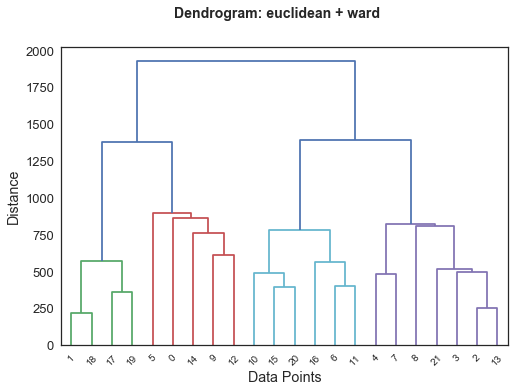

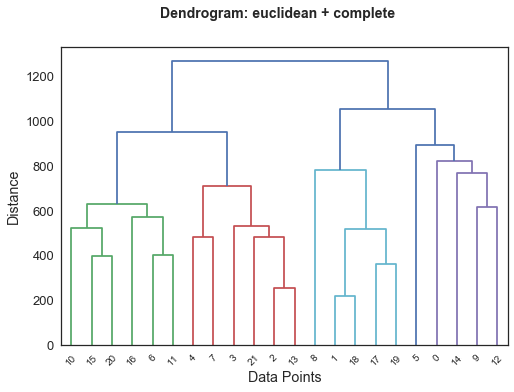

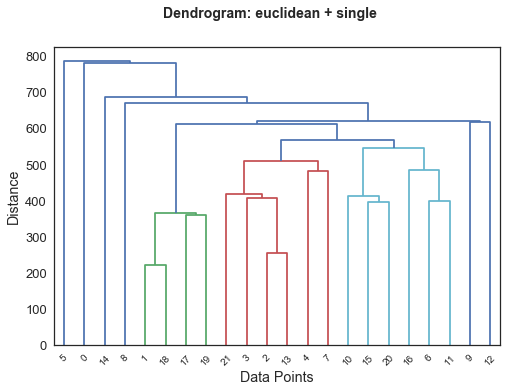

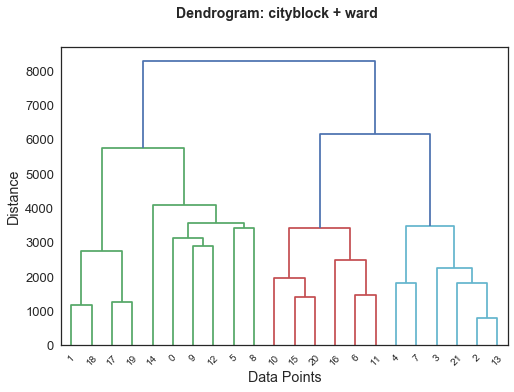

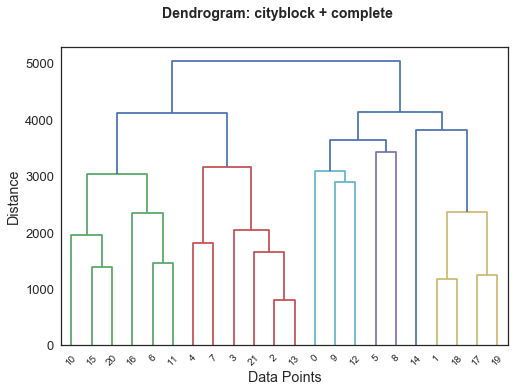

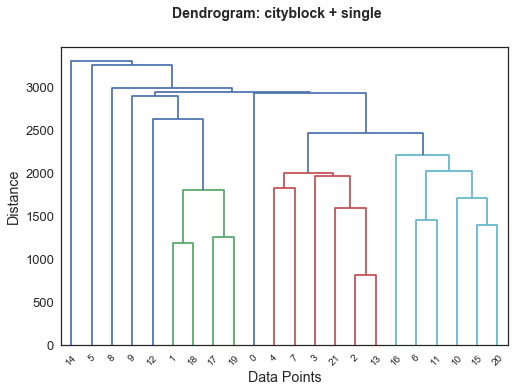

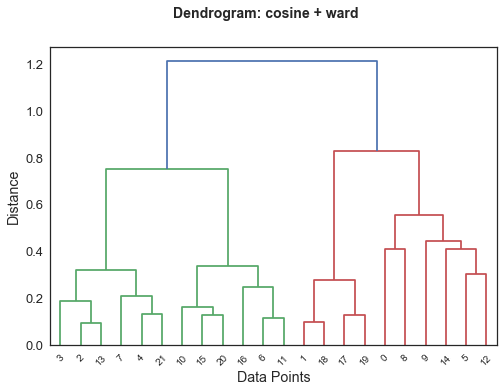

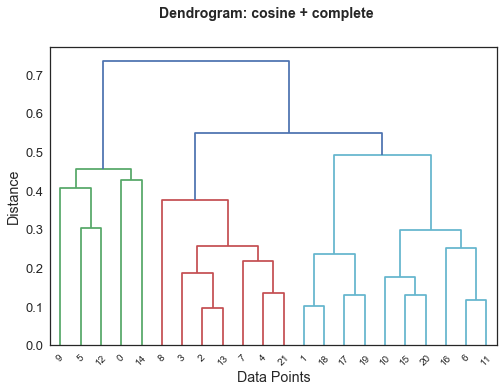

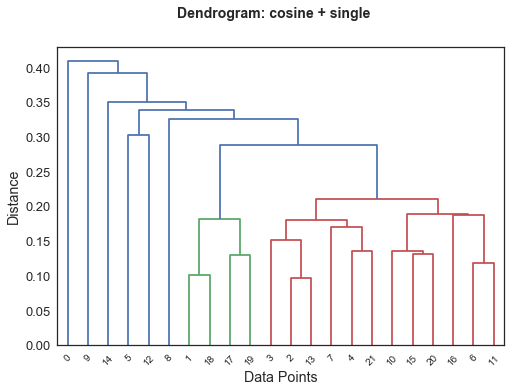

In [65]:
### YOUR CODE HERE
from sklearn.cluster import AgglomerativeClustering
Affinity = ["euclidean", 'cityblock',"cosine"]
Linkage = ["ward", "complete", "single"]

for agg in Affinity:
    for link in Linkage:
        
        # compute spatial distance matrix
        dist_lang = spd.squareform(spd.pdist(df_lang, metric=agg))
        
        # Perform hierarchical clustering
        Z_lang = sph.linkage(dist_lang,method=link)
                     
        # plot the dendrogram
        plt.figure()
        _ = sph.dendrogram(Z_lang)
        plt.xlabel('Data Points')
        plt.ylabel('Distance')
        plt.suptitle('Dendrogram: ' + agg + ' + ' + link, fontweight='bold', fontsize=14);

#### List the things you tried and any observations you had about the results

 <span style="color:red">I tried all 10 combinations of the following two parameter settings:</span>

 <span style="color:red">- Affinity = ["euclidean", 'cityblock',"cosine"]</span>
 
 <span style="color:red">- Linkage = ["ward", "complete", "single"]</span>

#### What was the best setting you found? Why do you think it's the best?

 <span style="color:red">eulidean + complete appears to be the best because it most closely resembles:</span>
 
 - <span style="color:red"> the complexity of the "indo-european" dendogram above</span>
 
 - <span style="color:red"> the medium to large number distances</span>
 
 - <span style="color:red"> the distance between clusters visually</span>
 


### Part 3: Character n-grams

Single characters are ok, but are not always great reflections of a language.  One improvement, that may seem weird at first but actually works, is using character n-grams.  Instead of using single letters, we use pairs of consecutive letters.  So a character bi-gram might be:  "er" and a tri-gram might be "ers."

The hackish way to do this is simply to remove all the blank spaces and then pull out two characters at a time. For example:

"apple fig" would become "applefig"

The bi-grams would be:

`ap, pp, pl, le, ef, fi, ig`

Notice that it's a sliding window... so characters overlap.  Tri-grams would be:

`app, ppl, ple, lef, efi, fig`

Copy your code above and modify to produce either bi- or tri- grams.

A sample of the bi-gram table looks like:

![](langvis2.png "langvis2")

As a side note: you'll have far more 0's in this table then in the other one. To really make bi-grams or tri-grams work well we usually want more text than this.

In [97]:
### YOUR CODE HERE
import re
n = 2

# STEP ONE: get all n_grams across all languages
all_lang_letters = Counter({})
for lang in genesis:
    for line in genesis[lang]:
        line_edit1 = line.replace(" ", "").lower() # remove spaces
        line_edit2 = re.sub(r'\W+', '', line_edit1) # remove non-alpha-numeric characters
        line_edit3 = [line[i:i+n] for i in range(0, len(line_edit2), n)] # reduce to n_grams
        current_line_count = Counter(line_edit3) # get n_gram count for current line
        all_lang_letters += current_line_count # index for all languages

# STEP TWO: only keep the alphanumeric characters you want
all_lang_letters = {key: value for key, value in all_lang_letters.items() if key.isalpha()}

In [98]:
# STEP THREE: gather individual language counts
df_lang = pd.DataFrame()
for lang in genesis:
    current_lang = Counter({key: 0 for key in all_lang_letters})
    for line in genesis[lang]:
        line_edit1 = line.replace(" ", "").lower() # lowercase and remove spaces
        line_edit2 = re.sub(r'\W+', '', line_edit1) # remove non-alpha-numeric characters
        line_edit3 = [line[i:i+n] for i in range(0, len(line_edit2), n)] # reduce to n_grams
        
        current_line_count = Counter(line_edit3) # get n_gram count for current line
        current_line_count = Counter({key: value for key, value in current_line_count.items() if key.isalpha()}) # clean up
        current_lang.update(current_line_count.elements()) # index for current language
        
    df_row = pd.DataFrame(current_lang, index=[lang,]) # make DataFrame row out of totals
    df_lang = df_lang.append(df_row) # append row to DataFrame of all languages

In [99]:
df_lang

Ab  Af  Ai  An  Ar  As  Bi  Bl  Bo  Bu ...  že  ži  žj  žm  žs  \
Albanian     0   0   1   0   0   0   0   0   0   0 ...   0   0   0   0   0   
Czech        0   0   0   0   0   0   0   0   1   2 ...   3   3   0   0   0   
Danish       0   3   0   0   5   0   0   1   0   0 ...   0   0   0   0   0   
Dutch        0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
English      0   0   0   2   0   0   0   0   0   0 ...   0   0   0   0   0   
Finnish      0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
French       0   0   2   0   0   0   0   0   0   0 ...   0   0   0   0   0   
German       1   0   0   1   5   0   2   0   0   0 ...   0   0   0   0   0   
Hungarian    0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
Icelandic    0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
Italian      0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
Latin        0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
Lithuanian   0   0   0   0   0   0   0   0   0   0 ...   6   2   0   1   0   
Norwegian    0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
Polish       0   0   0   0   0   0   0   0   1   0 ...   0   0   0   0   0   
Portuguese   0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
Romanian     0   0   0   0   0   2   0   0   0   0 ...   0   0   0   0   0   
Serbian      0   0   0   0   0   0   0   0  23   0 ...   0   6   1   0   0   
Slovak       0   0   0   0   0   0   0   0   0   0 ...   0   6   0   0   1   
Slovene      0   0   0   0   0   0   0   0  15   0 ...   0   6   7   0   0   
Spanish      0   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
Swedish      0   0   0   1   0   0   0   0   0   0 ...   0   0   0   0   0   

            žt  žu  žy  ží  žď  
Albanian     0   0   0   0   0  
Czech        2   1   0   1   1  
Danish       0   0   0   0   0  
Dutch        0   0   0   0   0  
English      0   0   0   0   0  
Finnish      0   0   0   0   0  
French       0   0   0   0   0  
German       0   0   0   0   0  
Hungarian    0   0   0   0   0  
Icelandic    0   0   0   0   0  
Italian      0   0   0   0   0  
Latin        0   0   0   0   0  
Lithuanian   0   1   1   0   0  
Norwegian    0   0   0   0   0  
Polish       0   0   0   0   0  
Portuguese   0   0   0   0   0  
Romanian     0   0   0   0   0  
Serbian      0   0   0   0   0  
Slovak       1   1   0   0   0  
Slovene      0   0   0   0   0  
Spanish      0   0   0   0   0  
Swedish      0   0   0   0   0  

[22 rows x 1055 columns]

/Users/AJGoldstein/anaconda/envs/si370/lib/python3.6/site-packages/ipykernel/__main__.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


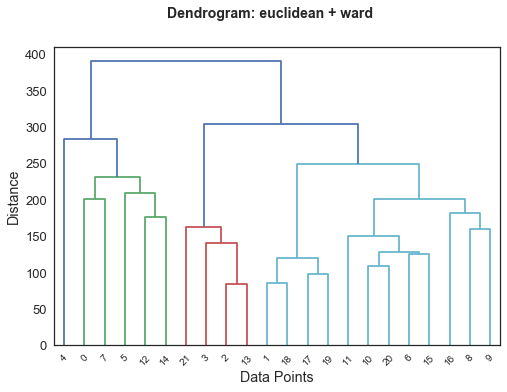

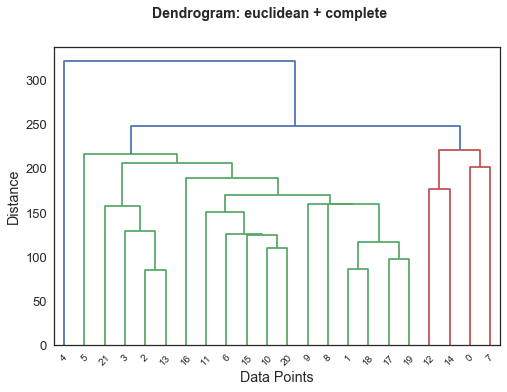

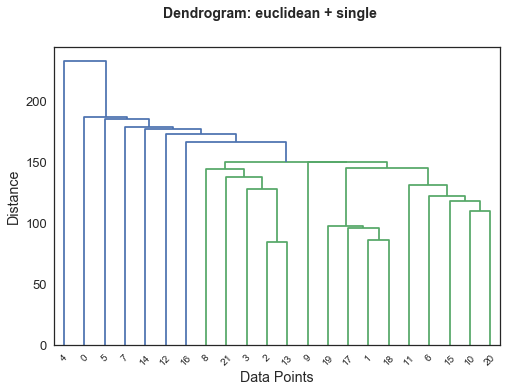

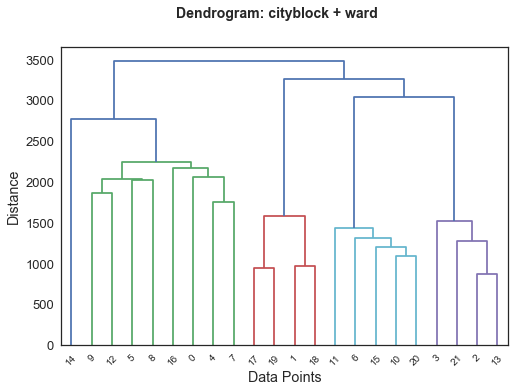

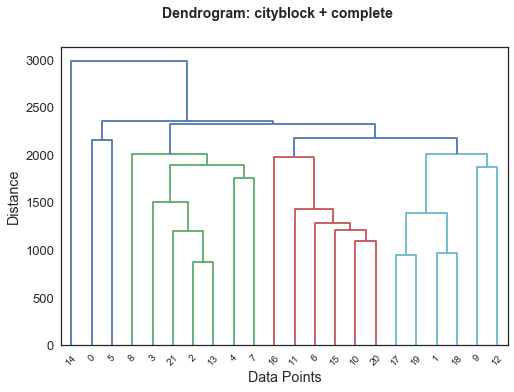

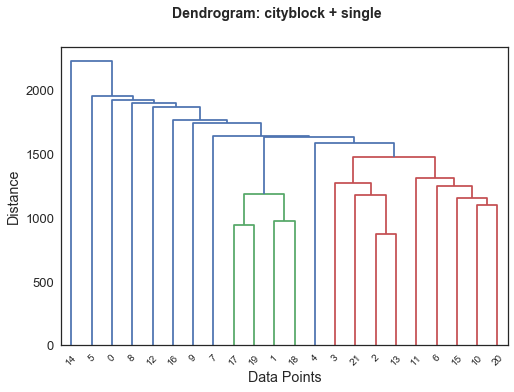

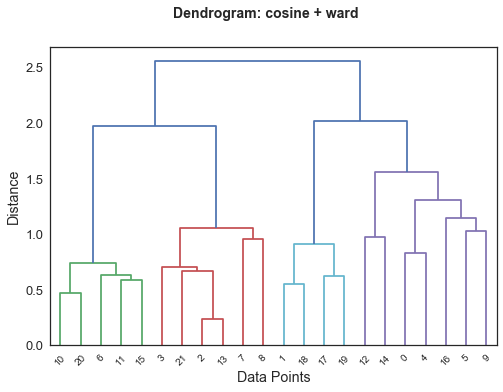

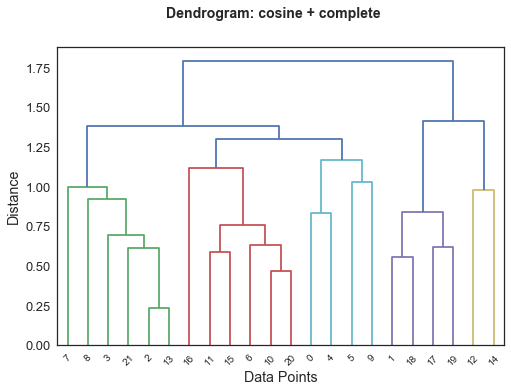

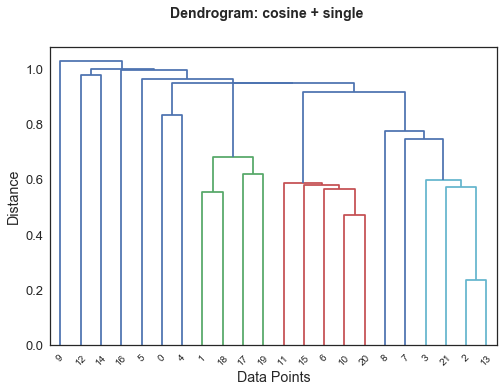

In [100]:
### YOUR CODE HERE
from sklearn.cluster import AgglomerativeClustering
Affinity = ["euclidean", 'cityblock',"cosine"]
Linkage = ["ward", "complete", "single"]

for agg in Affinity:
    for link in Linkage:
        
        # compute spatial distance matrix
        dist_lang = spd.squareform(spd.pdist(df_lang, metric=agg))
        
        # Perform hierarchical clustering
        Z_lang = sph.linkage(dist_lang,method=link)
                     
        # plot the dendrogram
        plt.figure()
        _ = sph.dendrogram(Z_lang)
        plt.xlabel('Data Points')
        plt.ylabel('Distance')
        plt.suptitle('Dendrogram: ' + agg + ' + ' + link, fontweight='bold', fontsize=14);